In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import scipy.stats as stats
from scipy.stats import zscore
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import pingouin as pg
import plotly.express as px 
import plotly.io as pio
pio.renderers.default='browser'
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
# Carregar a base de dados (substitua pelo caminho do seu arquivo)
df = pd.read_csv(r'C:\Users\act\Downloads\analise_vendedores.csv', sep=";", encoding = "cp1252", decimal = ',')

df.head(5)

,id_vendedor,nome_vendedor,categorias_atendidas,qtde_distinta_produtos,media_preco,qtde_disponivel_estoque,total_valor_estoque_usd,reputacao,status_vendedor,total_transacoes,vendas_estimativa
0,100471,TECNO-OUTLET,1,1,4.20,1,4.20,5_green,platinum,2831,11890.20
1,101217,WSBTECHNO,1,1,5.97,1,5.97,5_green,silver,1133,6764.01
2,104410,MONGETUNSA,1,1,7.68,1,7.68,4_light_green,NaN,479,3678.72
3,110162,COMPUFANSTORE,1,1,114.80,500,57399.37,5_green,platinum,33733,3872548.40
4,111286,WACKY_,1,5,22.04,1551,32036.93,5_green,platinum,82878,1826631.12


In [5]:
#2. Explorando os dados

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4172 entries, 0 to 4171
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_vendedor              4172 non-null   int64  
 1   nome_vendedor            4172 non-null   object 
 2   categorias_atendidas     4172 non-null   int64  
 3   qtde_distinta_produtos   4172 non-null   int64  
 4   media_preco              4172 non-null   float64
 5   qtde_disponivel_estoque  4172 non-null   int64  
 6   total_valor_estoque_usd  4172 non-null   float64
 7   reputacao                3323 non-null   object 
 8   status_vendedor          2855 non-null   object 
 9   total_transacoes         4172 non-null   int64  
 10  vendas_estimativa        4172 non-null   float64
dtypes: float64(3), int64(5), object(3)
memory usage: 358.7+ KB
None
        id_vendedor  categorias_atendidas  qtde_distinta_produtos  \
count  4.172000e+03           4172.000000            

In [7]:
# Tratamento de dados

# Preenchendo valores nulos
df.fillna({"reputacao": "desconhecido", "status_vendedor": "desconhecido"}, inplace=True)

In [9]:
# Convertendo reputação e status do vendedor para variáveis numéricas (one-hot encoding)
categorical_features = ["reputacao", "status_vendedor"]
num_features = ["categorias_atendidas", "qtde_distinta_produtos", "media_preco", 
                "qtde_disponivel_estoque", "total_valor_estoque_usd", "total_transacoes", 
                "vendas_estimativa"]

In [11]:
# Criando pipeline de transformação
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),  
    ("cat", OneHotEncoder(drop="first"), categorical_features)  
])


In [13]:
# Aplicando transformação
df_cluster = preprocessor.fit_transform(df)

In [15]:
# Criando os clusters
cluster_hier = AgglomerativeClustering(n_clusters=4, linkage='complete')
df["cluster_hier"] = cluster_hier.fit_predict(df_cluster)


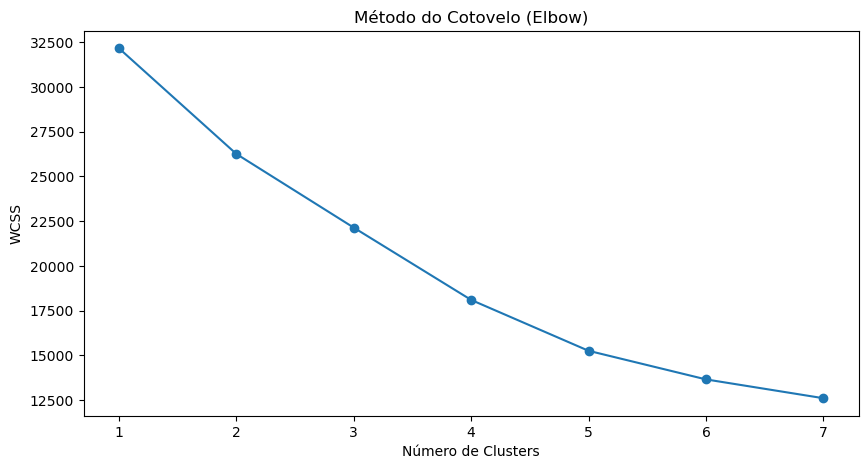

In [17]:
# Clusterização K-Means

# Encontrando o número ideal de clusters (Elbow Method)
wcss = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, init='random', random_state=100)
    kmeans.fit(df_cluster)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(range(1, 8), wcss, marker="o")
plt.title("Método do Cotovelo (Elbow)")
plt.xlabel("Número de Clusters")
plt.ylabel("WCSS")
plt.show()

In [19]:
# Aplicando K-Means com 4 clusters (ajustável)
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
df["cluster_kmeans"] = kmeans.fit_predict(df_cluster)


In [21]:
#%% Analisando os Clusters

# Criando um DataFrame com a média das variáveis por cluster
df_clusters_resumo = df.groupby("cluster_kmeans")[num_features].mean()

# Exibindo a tabela de resumo
print(df_clusters_resumo)

                categorias_atendidas  qtde_distinta_produtos   media_preco  \
cluster_kmeans                                                               
0                           1.000000                7.710526  38495.826633   
1                           1.163558                2.020161    124.443221   
2                           1.352941                7.058824     94.370187   
3                           4.090090               19.630631    126.527120   

                qtde_disponivel_estoque  total_valor_estoque_usd  \
cluster_kmeans                                                     
0                              7.710526             2.949607e+05   
1                            422.528730             1.304786e+04   
2                          90167.882353             3.239097e+06   
3                           3834.414414             2.224105e+05   

                total_transacoes  vendas_estimativa  
cluster_kmeans                                       
0             

In [49]:
import pingouin as pg


# Definindo o formato para evitar notação científica
pd.options.display.float_format = '{:,.6f}'.format  # Exibe até 6 casas decimais

# Selecionando as variáveis numéricas usadas na clusterização
num_features = ["qtde_distinta_produtos", "media_preco", "qtde_disponivel_estoque", 
                "total_valor_estoque_usd", "total_transacoes", "vendas_estimativa"]

# Criando uma tabela para armazenar os resultados
anova_results = pd.DataFrame()

# Rodando ANOVA para cada variável
for var in num_features:
    anova = pg.anova(dv=var, between="cluster_kmeans", data=df, detailed=True)
    anova["variavel"] = var
    anova_results = pd.concat([anova_results, anova])

# Resetar o formato após exibição, se necessário
pd.reset_option("display.float_format")

# Exibir resultados
print("\nResultados ANOVA:")
display(anova_results)



Resultados ANOVA:


,Source,SS,DF,MS,F,p-unc,np2,variavel
0,cluster_kmeans,3.585101e+04,3,1.195034e+04,510.501266,1.555418e-282,0.268708,qtde_distinta_produtos
1,Within,9.756882e+04,4168,2.340902e+01,NaN,NaN,NaN,qtde_distinta_produtos
0,cluster_kmeans,1.098616e+11,3,3.662052e+10,10244.718551,0.000000e+00,0.880580,media_preco
1,Within,1.489883e+10,4168,3.574576e+06,NaN,NaN,NaN,media_preco
0,cluster_kmeans,1.373864e+11,3,4.579545e+10,3309.201134,0.000000e+00,0.704305,qtde_disponivel_estoque
1,Within,5.768022e+10,4168,1.383882e+07,NaN,NaN,NaN,qtde_disponivel_estoque
0,cluster_kmeans,1.854579e+14,3,6.181929e+13,2394.684451,0.000000e+00,0.632842,total_valor_estoque_usd
1,Within,1.075978e+14,4168,2.581521e+10,NaN,NaN,NaN,total_valor_estoque_usd
0,cluster_kmeans,5.225026e+12,3,1.741675e+12,790.879809,0.000000e+00,0.362753,total_transacoes
1,Within,9.178768e+12,4168,2.202200e+09,NaN,NaN,NaN,total_transacoes


In [25]:
from scipy.stats import kruskal

# Criando uma tabela para armazenar os resultados
kruskal_results = []

# Rodando o teste para cada variável numérica
for var in num_features:
    groups = [df[df["cluster_kmeans"] == c][var] for c in df["cluster_kmeans"].unique()]
    stat, p_value = kruskal(*groups)
    kruskal_results.append([var, stat, p_value])

# Criando DataFrame com os resultados
df_kruskal = pd.DataFrame(kruskal_results, columns=["Variável", "Estatística Kruskal", "p-valor"])

# Exibir resultados
print("\nResultados Kruskal-Wallis:")
df_kruskal


Resultados Kruskal-Wallis:


,Variável,Estatística Kruskal,p-valor
0,qtde_distinta_produtos,481.378065,5.178023e-104
1,media_preco,249.446990,8.618552e-54
2,qtde_disponivel_estoque,301.086055,5.790479e-65
3,total_valor_estoque_usd,466.805012,7.447574e-101
4,total_transacoes,420.881040,6.635772e-91
5,vendas_estimativa,373.502157,1.214177e-80


In [27]:
from scipy.stats import chi2_contingency

# Criando tabelas de contingência
contingencia_status = pd.crosstab(df["cluster_kmeans"], df["status_vendedor"])
contingencia_reputacao = pd.crosstab(df["cluster_kmeans"], df["reputacao"])

# Teste Qui-Quadrado para status do vendedor
stat_status, p_status, _, _ = chi2_contingency(contingencia_status)
stat_reputacao, p_reputacao, _, _ = chi2_contingency(contingencia_reputacao)

# Criando DataFrame com os resultados
df_chi2 = pd.DataFrame({
    "Variável": ["Status do Vendedor", "Reputação"],
    "Estatística Qui-Quadrado": [stat_status, stat_reputacao],
    "p-valor": [p_status, p_reputacao]
})

# Exibir resultados
print("\nResultados Qui-Quadrado:")
df_chi2


Resultados Qui-Quadrado:


,Variável,Estatística Qui-Quadrado,p-valor
0,Status do Vendedor,238.556637,2.589574e-46
1,Reputação,328.800112,5.631197e-61


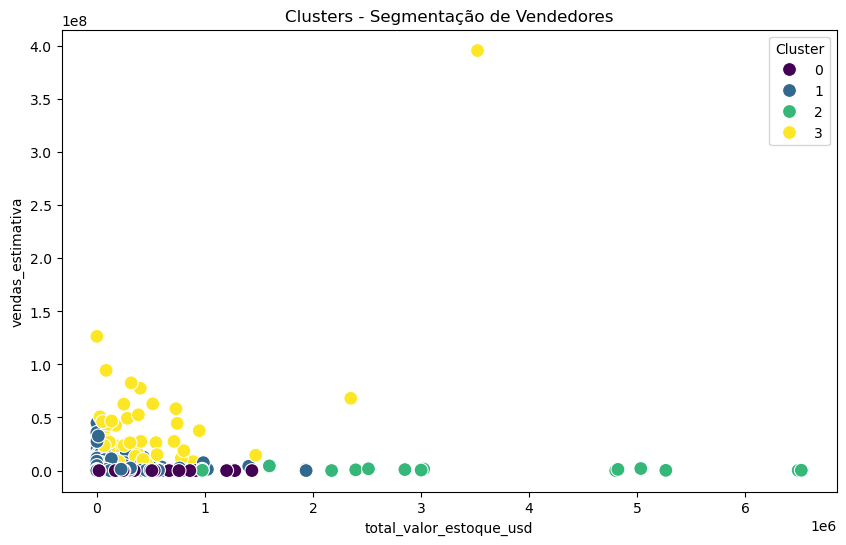

In [29]:
# Visualizando os Clusters

plt.figure(figsize=(10,6))
sns.scatterplot(x=df["total_valor_estoque_usd"], y=df["vendas_estimativa"], hue=df["cluster_kmeans"], palette="viridis", s=100)
plt.xlabel("total_valor_estoque_usd")
plt.ylabel("vendas_estimativa")
plt.title("Clusters - Segmentação de Vendedores")
plt.legend(title="Cluster")
plt.show()

In [31]:
# Verificando os nomes das colunas disponíveis
print(df.columns)

# Gráfico 3D dos Clusters com categoria do vendedor (substitua pela coluna correta)
fig = px.scatter_3d(df, 
                    x="media_preco", 
                    y="total_transacoes", 
                    z="qtde_distinta_produtos",
                    color=df["cluster_kmeans"].astype(str),  # Colorir pelos clusters
                    hover_data=["nome_vendedor", "categorias_atendidas"])  # Usar a coluna correta
fig.show()

Index(['id_vendedor', 'nome_vendedor', 'categorias_atendidas',
       'qtde_distinta_produtos', 'media_preco', 'qtde_disponivel_estoque',
       'total_valor_estoque_usd', 'reputacao', 'status_vendedor',
       'total_transacoes', 'vendas_estimativa', 'cluster_hier',
       'cluster_kmeans'],
      dtype='object')


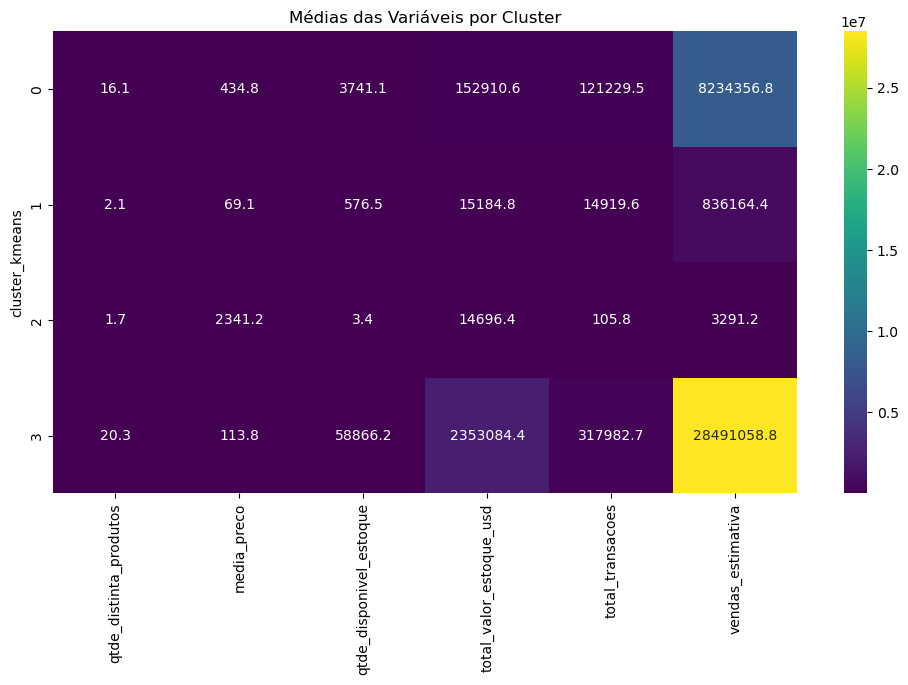

In [166]:
# Agrupar os dados por cluster e calcular a média das variáveis numéricas
df_clusters_resumo = df.groupby("cluster_kmeans")[[
    "qtde_distinta_produtos", "media_preco", "qtde_disponivel_estoque",
    "total_valor_estoque_usd", "total_transacoes", "vendas_estimativa"
]].mean().reset_index()


# Visualizar as médias das variáveis por cluster
plt.figure(figsize=(12, 6))
sns.heatmap(df_clusters_resumo.set_index("cluster_kmeans"), annot=True, fmt=".1f", cmap="viridis")
plt.title("Average of varibles by Cluster")
plt.show()


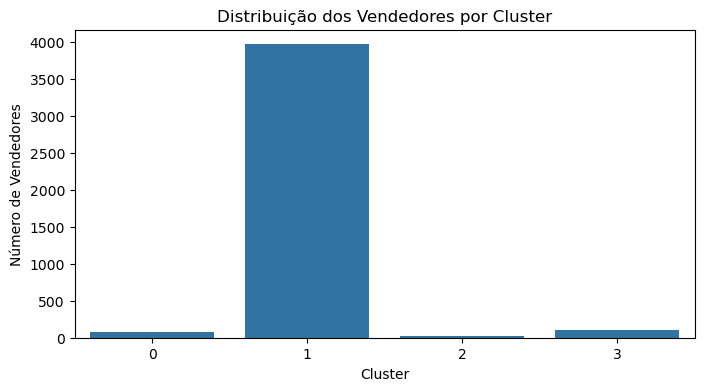

In [33]:

#Distribuição dos Clusters
plt.figure(figsize=(8, 4))
sns.countplot(x=df["cluster_kmeans"])
plt.title("Sellers Distribution by Clusters")
plt.xlabel("Cluster")
plt.ylabel("Number of Sellers")
plt.show()


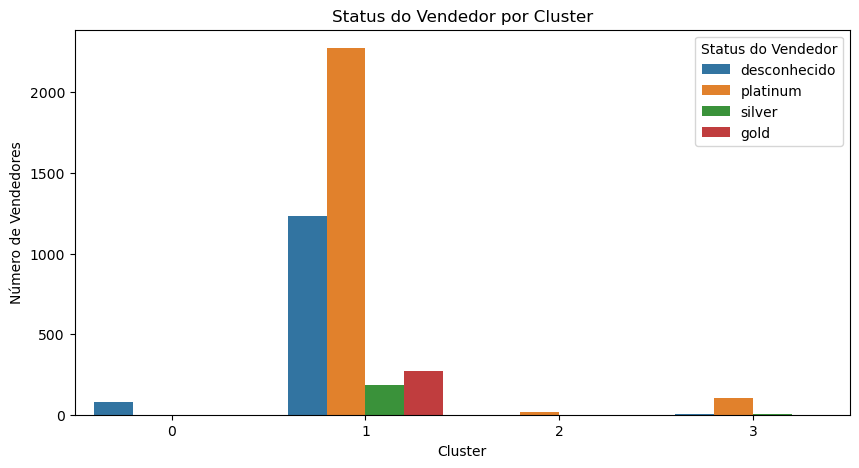

In [35]:
# Analisando os Clusters pelo Status do Vendedor
# Queremos entender se há uma concentração de vendedores Platinum, Gold ou Silver em algum cluster.

plt.figure(figsize=(10, 5))
sns.countplot(x=df["cluster_kmeans"], hue=df["status_vendedor"])
plt.title("Seller Status by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Sellers")
plt.legend(title="Sellers Status")
plt.show()


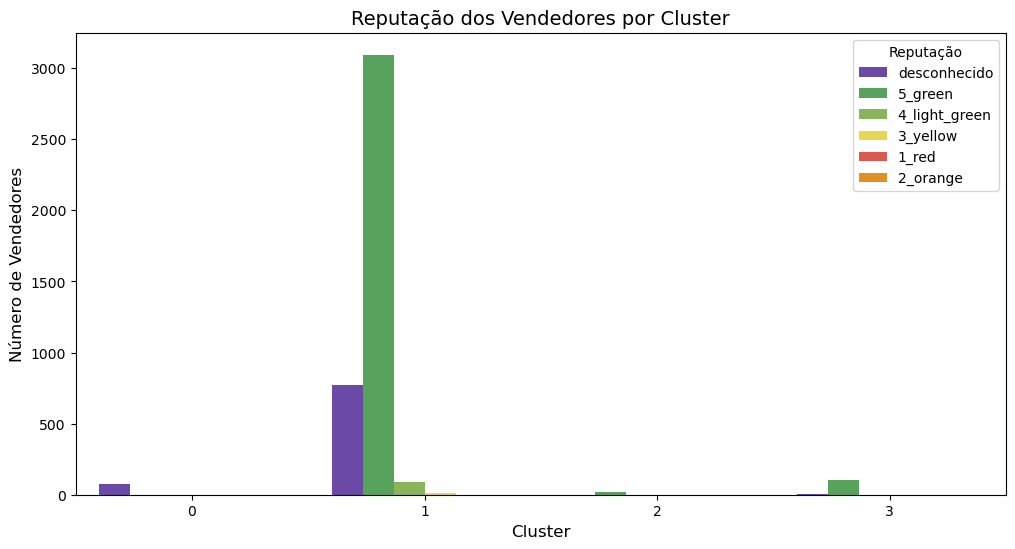

In [37]:
# Definir um dicionário de cores para cada reputação
cores_reputacao = {
    "5_green": "#4CAF50",       # Verde forte
    "4_light_green": "#8BC34A", # Verde claro
    "3_yellow": "#FFEB3B",      # Amarelo
    "2_orange": "#FF9800",      # Laranja
    "1_red": "#F44336",         # Vermelho
    "desconhecido": "#673AB7"   # Roxo (para valores desconhecidos)
}

# Criar o gráfico com a paleta personalizada
plt.figure(figsize=(12, 6))
sns.countplot(
    x=df["cluster_kmeans"], 
    hue=df["reputacao"], 
    palette=cores_reputacao
)

# Ajustar os títulos e rótulos
plt.title("Sellers Reputation by Clusters", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Number of Sellers", fontsize=12)
plt.legend(title="Reputation", fontsize=10)
plt.show()


In [39]:
# Criando uma tabela resumo dos clusters
df_cluster_summary = df.groupby("cluster_kmeans").agg(
    total_vendedores=("id_vendedor", "count"),  # Contando a quantidade de vendedores
    total_estoque=("qtde_disponivel_estoque", "sum"),
    total_estimativa=("vendas_estimativa", "sum"),
    total_transacoes=("total_transacoes", "sum")
).reset_index()

# Calculando os shares (%)
df_cluster_summary["share_estoque"] = df_cluster_summary["total_estoque"] / df_cluster_summary["total_estoque"].sum() * 100
df_cluster_summary["share_estimativa"] = df_cluster_summary["total_estimativa"] / df_cluster_summary["total_estimativa"].sum() * 100
df_cluster_summary["share_transacoes"] = df_cluster_summary["total_transacoes"] / df_cluster_summary["total_transacoes"].sum() * 100
df_cluster_summary["share_vendedores"] = df_cluster_summary["total_vendedores"] / df_cluster_summary["total_vendedores"].sum() * 100

# Calculando o Ticket Médio por Vendedor
df_cluster_summary["Estoque Medio p Vendedor"] = df_cluster_summary["total_estoque"] / df_cluster_summary["total_vendedores"]
df_cluster_summary["Estimativa Vendas p Vendedor"] = df_cluster_summary["total_estimativa"] / df_cluster_summary["total_vendedores"]

# Renomeando as colunas
df_cluster_summary.rename(columns={
    "cluster_kmeans": "Cluster",
    "total_vendedores": "Quantidade de Vendedores",
    "total_estoque": "Total em Estoque",
    "share_estoque": "Share Estoque (%)",
    "total_estimativa": "Total Estimativa ($)",
    "share_estimativa": "Share Estimativa (%)",
    "total_transacoes": "Total Transações",
    "share_transacoes": "Share Transações (%)",
    "share_vendedores": "Share Vendedores (%)"
}, inplace=True)

# Formatando os números para melhor visualização
df_cluster_summary["Total em Estoque"] = df_cluster_summary["Total em Estoque"].apply(lambda x: f"{x:,.0f}")
df_cluster_summary["Total Estimativa ($)"] = df_cluster_summary["Total Estimativa ($)"].apply(lambda x: f"{x/1e6:.2f}M")
df_cluster_summary["Total Transações"] = df_cluster_summary["Total Transações"].apply(lambda x: f"{x:,.0f}")
df_cluster_summary["Quantidade de Vendedores"] = df_cluster_summary["Quantidade de Vendedores"].apply(lambda x: f"{x:,.0f}")
df_cluster_summary["Estoque Medio p Vendedor"] = df_cluster_summary["Estoque Medio p Vendedor"].apply(lambda x: f"{x:,.0f}")
df_cluster_summary["Estimativa Vendas p Vendedor"] = df_cluster_summary["Estimativa Vendas p Vendedor"].apply(lambda x: f"{x/1e6:.2f}M")

# Formatando os shares para exibir com porcentagem
df_cluster_summary["Share Estoque (%)"] = df_cluster_summary["Share Estoque (%)"].apply(lambda x: f"{x:.1f}%")
df_cluster_summary["Share Estimativa (%)"] = df_cluster_summary["Share Estimativa (%)"].apply(lambda x: f"{x:.1f}%")
df_cluster_summary["Share Transações (%)"] = df_cluster_summary["Share Transações (%)"].apply(lambda x: f"{x:.1f}%")
df_cluster_summary["Share Vendedores (%)"] = df_cluster_summary["Share Vendedores (%)"].apply(lambda x: f"{x:.1f}%")


In [171]:
df_cluster_summary

,Cluster,Quantidade de Vendedores,Total em Estoque,Total Estimativa ($),Total Transações,Share Estoque (%),Share Estimativa (%),Share Transações (%),Share Vendedores (%),Estoque Medio p Vendedor,Estimativa Vendas p Vendedor
0,0,221,"826,790",1819.79M,"26,791,712",18.4%,33.4%,31.2%,4.9%,"3,741",8.23M
1,1,"3,311","1,908,744",2768.54M,"49,398,656",42.4%,50.8%,57.6%,73.1%,576,0.84M
2,2,966,"3,237",3.18M,"102,244",0.1%,0.1%,0.1%,21.3%,3,0.00M
3,3,30,"1,765,986",854.73M,"9,539,482",39.2%,15.7%,11.1%,0.7%,"58,866",28.49M


In [172]:
df_resultado_clusters = df[["id_vendedor", "nome_vendedor", "cluster_kmeans", "qtde_distinta_produtos", "media_preco", "qtde_disponivel_estoque",
    "total_valor_estoque_usd", "total_transacoes", "vendas_estimativa"]]

In [173]:
df_resultado_clusters.to_excel(r'C:\Users\act\Downloads\df_resultado_clusters.xlsx', index = False)